In [51]:
from tdavec.TDAvectorizer import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [2]:
from plotnine import ggplot, aes, geom_point, facet_grid, geom_line, geom_abline

Let us create some set of squessed ellipses:

In [20]:
np.random.seed(42)
epsList = np.random.uniform(low = 0, high = 1, size = 500)
clouds = [createEllipse(a=1, b=eps, n=100) for eps in epsList]

Here are some examples:

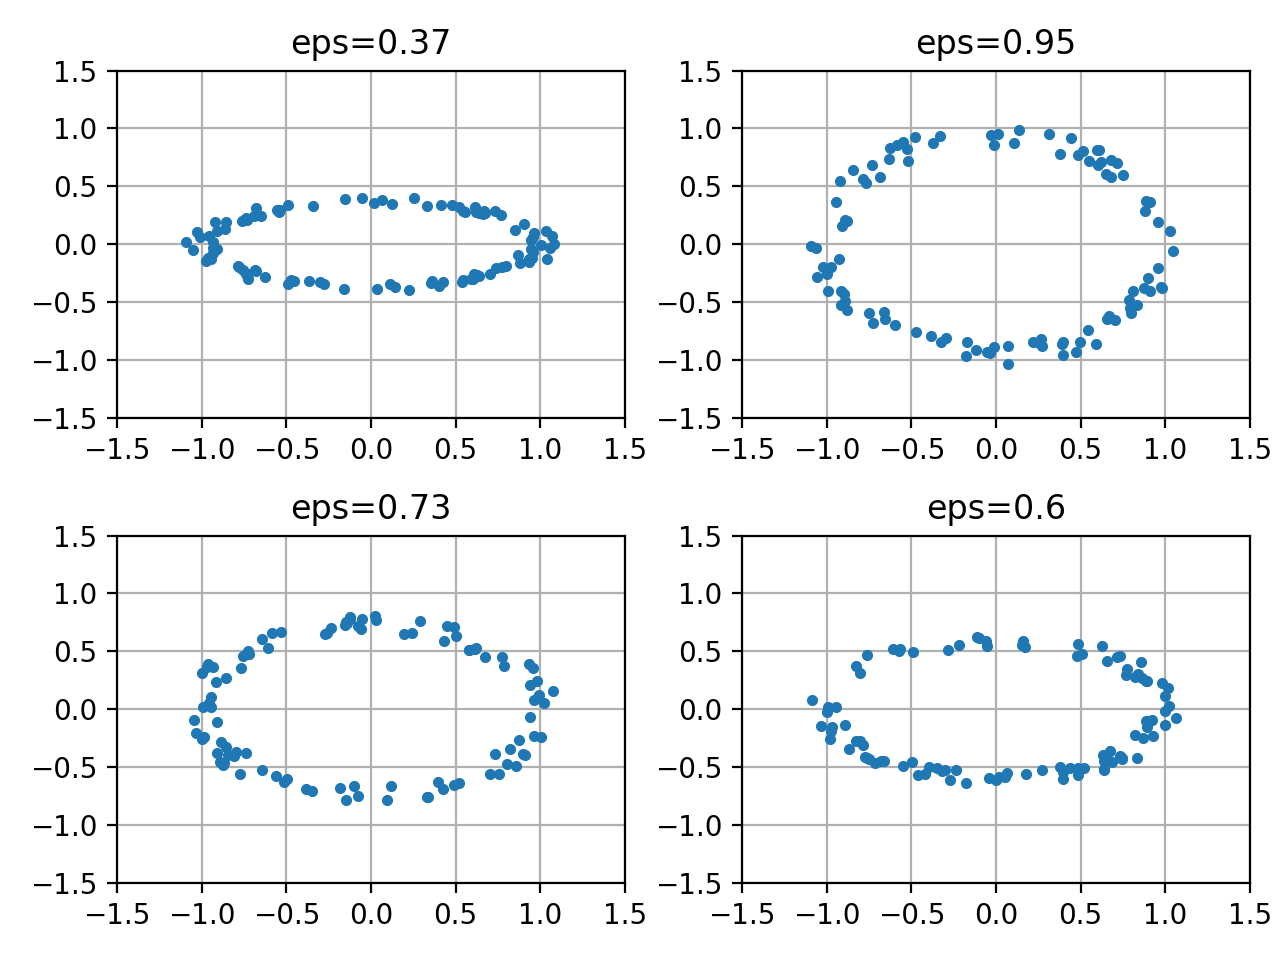

In [31]:
for i, cl in enumerate(clouds[:4]):
    plt.subplot(2, 2, i+1)
    plt.plot(cl[:,0], cl[:,1], ".")
    plt.xlim(-1.5, 1.5); plt.ylim(-1.5, 1.5)
    plt.title(f"eps={np.round(epsList[i], 2)}")
    plt.grid()
plt.tight_layout()

In [32]:
v = TDAvectorizer()
v.fit(clouds)

Here are the examples of the generated persistence diagrams:

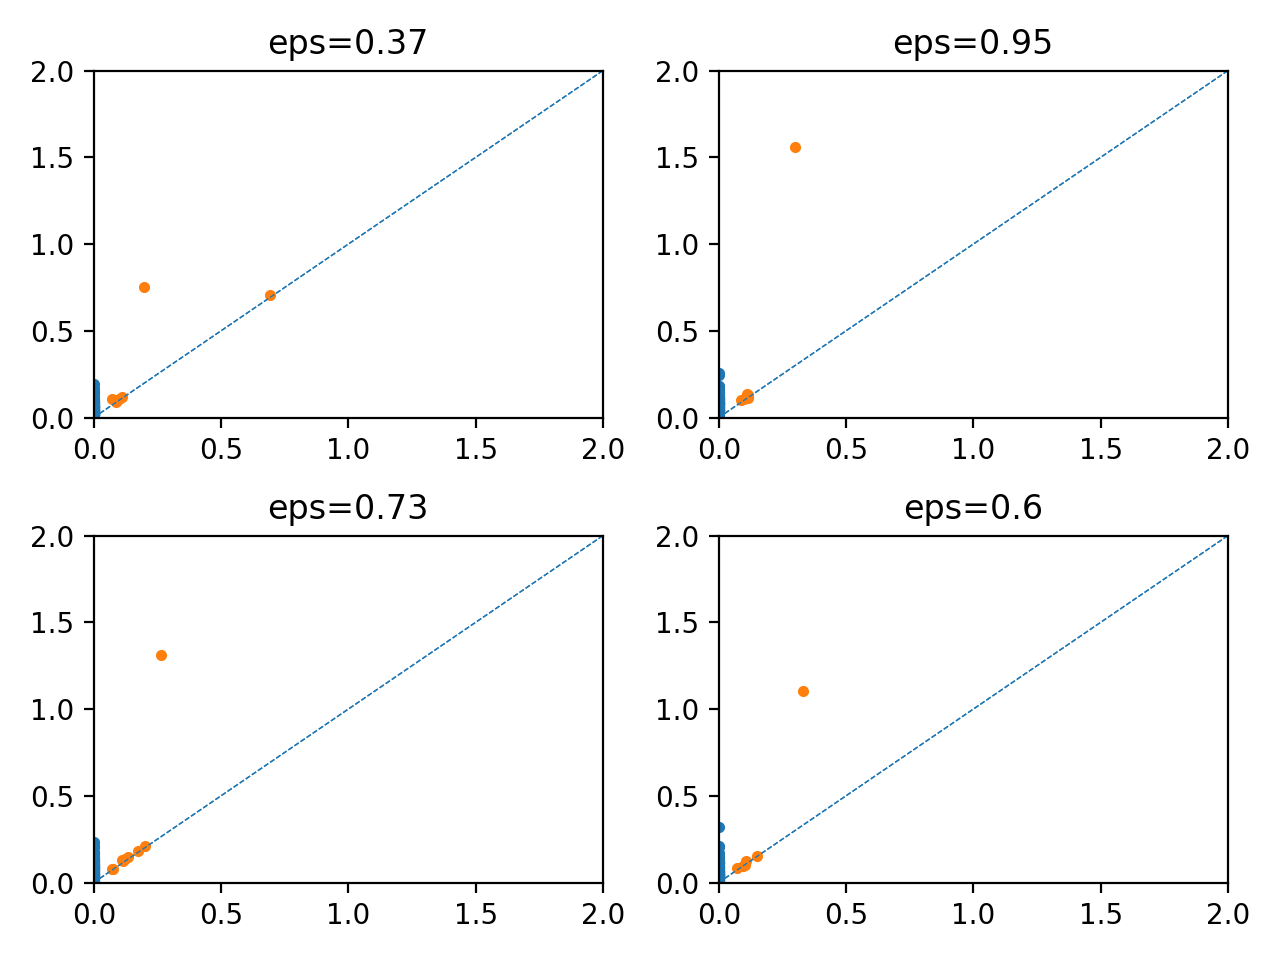

In [63]:
for i in range(4):
    plt.subplot(2,2,i+1)
    PD = v.diags[i]
    for dim in range(2):
        plt.plot(PD[dim][:,0], PD[dim][:,1], ".")
        plt.xlim(0, 2); plt.ylim(0, 2)
        plt.axline( (0,0), slope = 1, linestyle = "--", linewidth = 0.5)
        plt.title(f"eps={np.round(epsList[i], 2)}")
plt.tight_layout()

Here are some PS plots

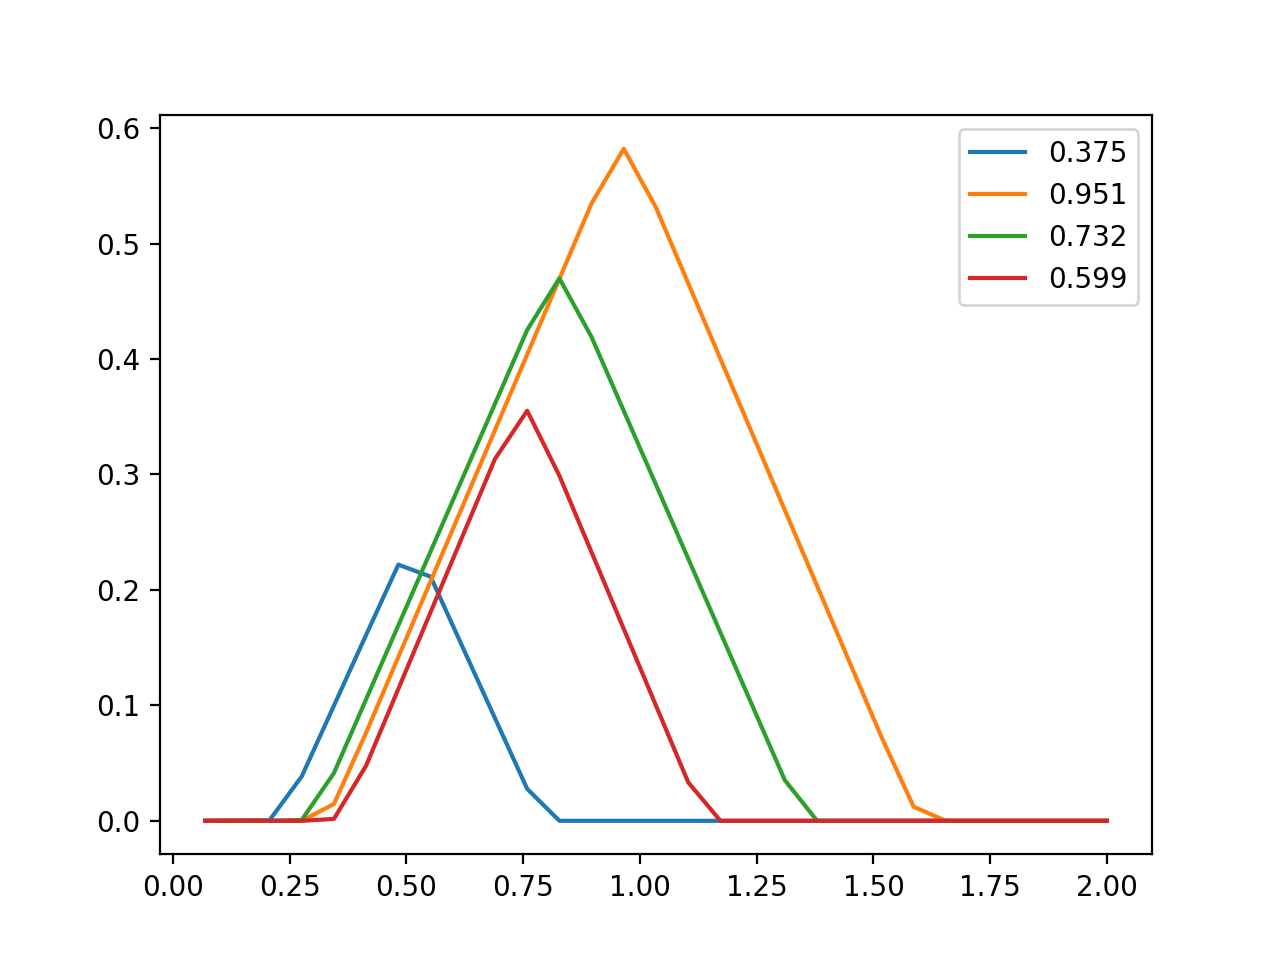

In [54]:
X = v.transform(output="PS", homDim=1)
for i, e in enumerate(epsList[:4]):
    plt.plot(v.getParams()["scale"][1:],X[i,:], label=np.round(e, 3))
plt.legend()


Let us now check different vectorization methods

Here is a function that uses specified vectorization method to solve the regression task and guess the squese factor:

In [49]:
v.setParams({"scale":np.linspace(0, 2, 30)})
methodList = ["vab", "ps", "nl", "ecc", "fda"]
def makeSim(method, homDim, vec = v, y=epsList):
    X =v.transform(output=method, homDim=homDim)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=42)
    model = LinearRegression().fit(Xtrain, ytrain)
    test_preds = model.predict(Xtest)
    score = model.score(Xtest, ytest)
    res = {"method":method, "homDim":homDim, "test_preds":test_preds, "y_test":ytest, "score":score}
    return res

In [64]:
results = []
df = pd.DataFrame()
for homDim in [0, 1]:
    for method in methodList:
        res = makeSim(method, homDim); results.append(res)
        df = pd.concat([df, pd.DataFrame(res)])
# df = df[["method", "homDim", "score"]].drop_duplicates()

df["homDim"] = df["homDim"].astype("category")

Here is the regression scores table for different vetcorizations 

In [65]:
df[["method", "homDim", "score"]].drop_duplicates().pivot(index="method", columns="homDim", values="score")

homDim,0,1
method,,
ecc,0.976142,0.996198
fda,0.983050,0.984793
nl,0.893031,0.980520
ps,0.903171,0.913956
vab,0.976142,0.985684


As you can see, they are very close to 1, so fits are pretty accurate

The same can be easily seen from presented below plots:

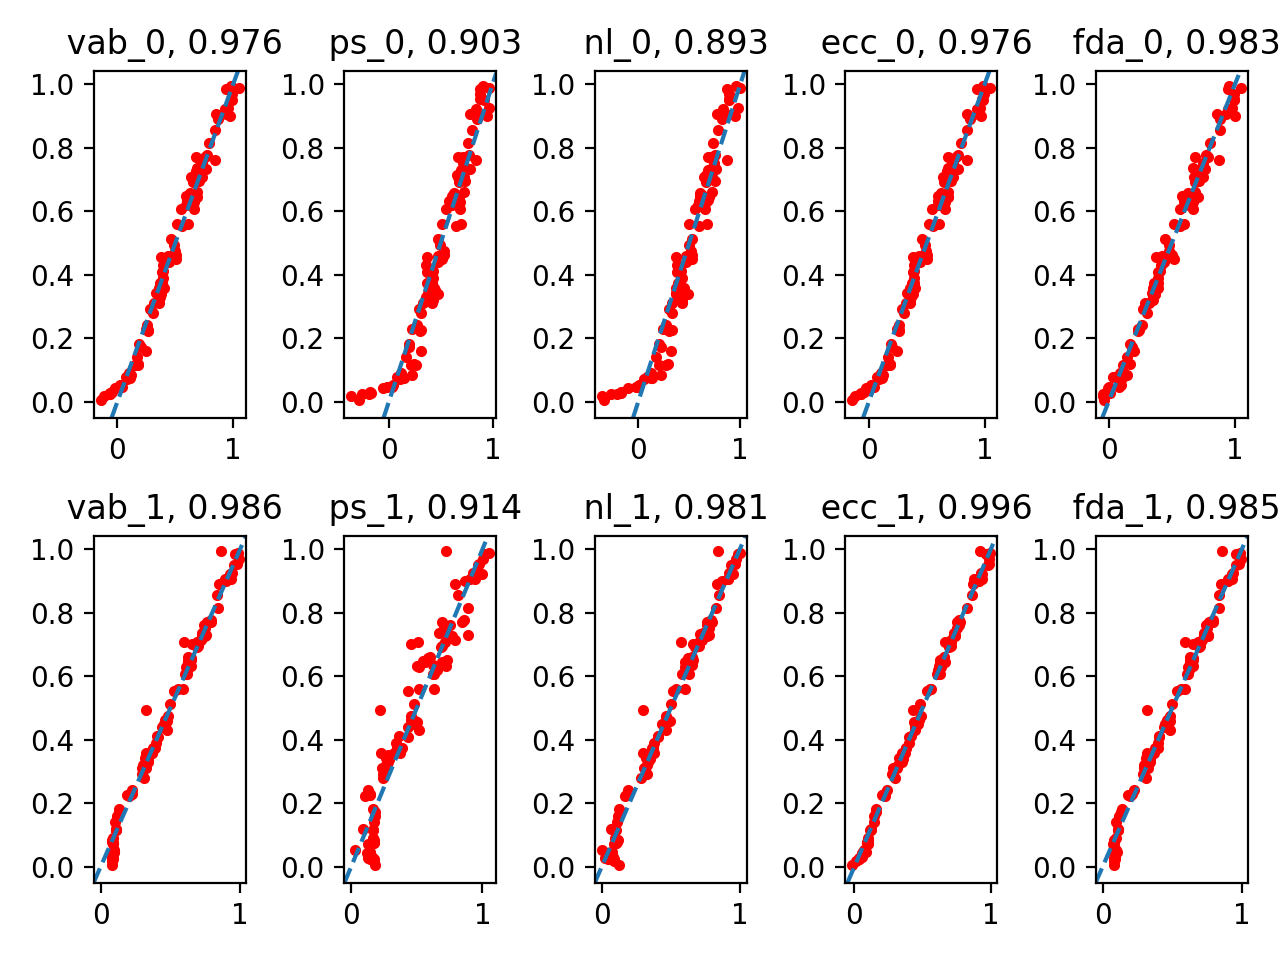

In [67]:
for i, r in enumerate(results):
    plt.subplot(2, 5, i+1)
    plt.plot(r["test_preds"], r["y_test"], "r.")
    plt.axline( (0,0), slope=1, linestyle = "--")
    plt.title(" {}_{}, {:.3f}".format(r["method"], r["homDim"], r["score"]))
plt.tight_layout()